In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 40)

# Use this to see how much memory the dataframes use
from sys import getsizeof

from vivarium_research_prl.noise import corruption, fake_names, noisify

!date
!whoami
!uname -a
!pwd

Fri 03 Feb 2023 01:59:49 PM PST
ndbs
Linux int-slurm-sarchive-p0004 5.4.0-89-generic #100-Ubuntu SMP Fri Sep 24 14:50:10 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/model_validation


# Load data

Slack message from Jim:
> latest run with results can be found here:
`/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21`.  This is after implementing post-processing for first names and middle initial so `final_results` will have names instead of name ideas.


In [2]:
project_output_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
output_subdir = 'results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21/'
output_dir = f'{project_output_dir}/{output_subdir}'

!ls -l $output_dir


total 1088
-rw-rw-r--  1 albrja IHME-Simulationscience      50 Feb  2 10:16 branches.yaml
drwxrwsr-x  3 albrja IHME-Simulationscience    1024 Feb  2 11:27 final_results
-rw-rw-r--  1 albrja IHME-Simulationscience     146 Feb  2 10:16 keyspace.yaml
drwxrwsr-x  3 albrja IHME-Simulationscience     512 Feb  2 10:16 logs
-rw-rw-r--  1 albrja IHME-Simulationscience    1931 Feb  2 10:16 model_specification.yaml
-rw-rw-r--  1 albrja IHME-Simulationscience 1064184 Feb  2 10:45 output.hdf
drwxr-sr-x  2 albrja IHME-Simulationscience     512 Feb  2 10:16 __pycache__
drwxrwsr-x 10 albrja IHME-Simulationscience    4096 Feb  2 10:41 raw_results
-rw-rw-r--  1 albrja IHME-Simulationscience    1745 Feb  2 10:16 requirements.txt
-rw-rw-r--  1 albrja IHME-Simulationscience     110 Feb  2 10:16 settings.py


In [3]:
!ls $output_dir/final_results

2023_02_02_11_10_52  latest


In [4]:
!ls -l $output_dir/final_results/2023_02_02_11_10_52

total 846760
-rw-r--r-- 1 albrja IHME-Simulationscience 116145705 Feb  2 11:20 decennial_census_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience   1436741 Feb  2 11:20 household_survey_observer_acs.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience   7443547 Feb  2 11:20 household_survey_observer_cps.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience  30294533 Feb  2 11:21 social_security_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience 696671121 Feb  2 11:27 tax_w2_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience  15056759 Feb  2 11:20 wic_observer.csv.bz2


In [5]:
!echo $output_dir

/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21/


In [6]:
# Apparently I can't see the contents of a symlinked directory using !ls
!ls -l /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21/final_results/latest


lrwxrwxrwx 1 albrja IHME-Simulationscience 33 Feb  2 11:27 /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21/final_results/latest -> final_results/2023_02_02_11_10_52


# Read in WIC data

In [7]:
%%time
output_subsubdir = 'final_results/2023_02_02_11_10_52'
df_wic = pd.read_csv(f'{output_dir}/{output_subsubdir}/wic_observer.csv.bz2')
df_wic

CPU times: user 2.67 s, sys: 160 ms, total: 2.83 s
Wall time: 2.88 s


,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,wic_year,random_seed,year_of_birth,first_name,middle_initial
0,7359_65,65.0,8.553950,Female,Black,2012-05-21,35,-1,-1,NaN,NaN,2021,7359,2012,Emma,M
1,7359_116,116.0,25.505874,Female,Black,1995-06-08,53,-1,-1,NaN,NaN,2021,7359,1995,Isabella,A
2,7359_212,211.0,30.291655,Female,Latino,1990-08-25,88,-1,-1,NaN,NaN,2021,7359,1990,Paige,L
3,7359_248,248.0,23.891573,Female,Black,1997-01-18,97912,-1,-1,NaN,NaN,2021,7359,1997,Michelle,M
4,7359_267,266.0,37.072670,Female,White,1983-11-13,109,-1,-1,NaN,NaN,2021,7359,1983,Maria,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593011,5020_277602,231367.0,0.041138,Male,Asian,2030-01-08,152642,231367,-1,152642.0,NaN,2030,5020,2030,Grayson,B
593012,5020_277607,237489.0,0.045699,Male,Latino,2030-01-07,135561,237490,-1,135561.0,NaN,2030,5020,2030,Tanner,E
593013,5020_277612,242914.0,0.039537,Female,Asian,2030-01-09,167694,242914,-1,167694.0,NaN,2030,5020,2030,Madison,S
593014,5020_277617,5210.0,0.054807,Male,Latino,2030-01-03,97484,5214,-1,97484.0,NaN,2030,5020,2030,Gavin,J


## Check memory usage of WIC data

About 270 MB for 590K rows.

In [8]:
# Size of WIC df is about 273 MB
getsizeof(df_wic)

273142122

# Read decennial census data

In [9]:
%%time
df_census = pd.read_csv(f'{output_dir}/{output_subsubdir}/decennial_census_observer.csv.bz2')
df_census

CPU times: user 27.5 s, sys: 1.41 s, total: 28.9 s
Wall time: 29 s


,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
0,3254_0,0.0,67.376229,Female,Black,1952-11-15,6,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1952,Deanna,S
1,3254_1,0.0,37.501003,Male,Black,1982-10-01,6,-1,-1,NaN,NaN,Biological child,2020,Standard,3254,1982,Clifton,S
2,3254_2,0.0,31.157344,Male,Black,1989-02-03,6,-1,-1,NaN,NaN,Biological child,2020,Standard,3254,1989,Christopher,S
3,3254_3,3.0,37.944355,Male,Latino,1982-04-22,7,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1982,Travis,J
4,3254_4,4.0,60.986418,Male,White,1959-04-07,8,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1959,Davis,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943280,3541_278165,44253.0,0.055643,Female,Latino,2030-03-28,150569,44253,-1,150569.0,NaN,Biological child,2030,Standard,3541,2030,Mila,C
4943281,3541_278166,50096.0,0.039506,Female,Black,2030-04-03,3,50097,-1,3.0,NaN,Noninstitutionalized GQ pop,2030,College,3541,2030,Aicha,L
4943282,3541_278167,113377.0,0.052213,Female,Black,2030-03-29,96003,113380,-1,96003.0,NaN,Biological child,2030,Standard,3541,2030,Amila,E
4943283,3541_278168,140942.0,0.016033,Female,Latino,2030-04-12,179963,140944,-1,179963.0,NaN,Grandchild,2030,Standard,3541,2030,Tallulah,S


## Check memory usage of decennial census data

About 3GB for 4.9M rows

In [10]:
# Size of decennial census is almost 3GB
getsizeof(df_census)

2957738342

# See column names

In [11]:
df_wic.dtypes

simulant_id               object
last_name_id             float64
age                      float64
sex                       object
race_ethnicity            object
date_of_birth             object
address_id                 int64
guardian_1                 int64
guardian_2                 int64
guardian_1_address_id    float64
guardian_2_address_id    float64
wic_year                   int64
random_seed                int64
year_of_birth              int64
first_name                object
middle_initial            object
dtype: object

In [12]:
df_census.dtypes

simulant_id                    object
last_name_id                  float64
age                           float64
sex                            object
race_ethnicity                 object
date_of_birth                  object
address_id                      int64
guardian_1                      int64
guardian_2                      int64
guardian_1_address_id         float64
guardian_2_address_id         float64
relation_to_household_head     object
census_year                     int64
housing_type                   object
random_seed                     int64
year_of_birth                   int64
first_name                     object
middle_initial                 object
dtype: object

# Look into why the first simulant in WIC is 8 years old

WIC is supposed to include only kids under 5 and women with infants (or pregnant women, but I don't think we implemented that).

Does the 8-year-old have an infant??? Yes!!!

In [13]:
# Check address of 8-year-old to see if there are any kids in it with her as a guardian
df_wic.loc[df_wic.address_id==35]

,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,wic_year,random_seed,year_of_birth,first_name,middle_initial
0,7359_65,65.0,8.553950,Female,Black,2012-05-21,35,-1,-1,NaN,NaN,2021,7359,2012,Emma,M
5214,7359_67,65.0,0.766598,Male,Black,2020-03-04,35,65,66,35.0,35.0,2021,7359,2020,Brooks,J
14003,7359_67,65.0,1.763176,Male,Black,2020-03-04,35,65,66,35.0,35.0,2022,7359,2020,Brooks,J
22644,7359_67,65.0,2.759754,Male,Black,2020-03-04,35,65,66,64392.0,35.0,2023,7359,2020,Brooks,J
176992,4344_68,67.0,26.652040,Female,Latino,1994-04-15,35,-1,-1,NaN,NaN,2021,4344,1994,Stephanie,I
182306,4344_69,67.0,0.766598,Female,Latino,2020-03-04,35,67,68,35.0,35.0,2021,4344,2020,Ivy,K
182307,4344_70,67.0,0.766598,Male,Latino,2020-03-04,35,67,68,35.0,35.0,2021,4344,2020,Casper,B
191187,4344_69,67.0,1.763176,Female,Latino,2020-03-04,35,67,68,0.0,103076.0,2022,4344,2020,Ivy,K
191188,4344_70,67.0,1.763176,Male,Latino,2020-03-04,35,67,68,0.0,103076.0,2022,4344,2020,Casper,B
241963,2787_80,76.0,0.766598,Female,Latino,2020-03-04,35,76,77,13511.0,35.0,2021,2787,2020,Sumaya,S


In [14]:
df_census.loc[df_census.address_id==35]

,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
71,3254_71,71.0,59.073084,Female,Asian,1961-03-06,35,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1961,Deanna,S
249886,3254_71,71.0,69.038861,Female,Asian,1961-03-06,35,-1,-1,NaN,NaN,Reference person,2030,Standard,3254,1961,Deanna,S
371270,3254_140108,140105.0,28.403219,Male,White,2001-10-24,35,-1,-1,NaN,NaN,Other nonrelative,2030,Standard,3254,2001,Tyler,J
494486,4344_67,67.0,27.681169,Male,Latino,1992-07-26,35,-1,-1,NaN,NaN,Reference person,2020,Standard,4344,1992,Daniel,T
494487,4344_68,67.0,25.962101,Female,Latino,1994-04-15,35,-1,-1,NaN,NaN,Opp-sex spouse,2020,Standard,4344,1994,Stephanie,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449341,3541_72,69.0,31.642394,Female,Latino,1988-08-10,35,-1,-1,NaN,NaN,Biological child,2020,Standard,3541,1988,Jessica,T
4699126,3541_69,69.0,71.666819,Female,Latino,1958-07-20,35,-1,-1,NaN,NaN,Reference person,2030,Standard,3541,1958,Mary,H
4699127,3541_70,69.0,51.660047,Female,Latino,1978-07-22,35,-1,-1,NaN,NaN,Biological child,2030,Standard,3541,1978,Kizzy,P
4699129,3541_72,69.0,41.608171,Female,Latino,1988-08-10,35,-1,-1,NaN,NaN,Biological child,2030,Standard,3541,1988,Jessica,T


In [15]:
df_census.loc[df_census.simulant_id=='7359_65']

,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
3460110,7359_65,65.0,7.864011,Female,Black,2012-05-21,35,-1,-1,NaN,NaN,Reference person,2020,Standard,7359,2012,Emma,M
3709954,7359_65,65.0,17.829788,Female,Black,2012-05-21,64392,-1,-1,NaN,NaN,Other nonrelative,2030,Standard,7359,2012,Emma,M


In [16]:
df_census.loc[df_census.simulant_id=='7359_66']

,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
3460111,7359_66,65.0,10.028877,Male,Black,2010-03-22,35,-1,-1,NaN,NaN,Opp-sex spouse,2020,Standard,7359,2010,Edwin,T
3709955,7359_66,65.0,19.994654,Male,Black,2010-03-22,4,-1,-1,NaN,NaN,Noninstitutionalized GQ pop,2030,Military,7359,2010,Edwin,T


## In the 2020 census, we have a 7-year-old married to a 10-year-old, and they have a one-month-old baby

In [17]:
df_census.query(
    "random_seed==7359 and address_id==35 and census_year==2020"
)

,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
3460110,7359_65,65.0,7.864011,Female,Black,2012-05-21,35,-1,-1,NaN,NaN,Reference person,2020,Standard,7359,2012,Emma,M
3460111,7359_66,65.0,10.028877,Male,Black,2010-03-22,35,-1,-1,NaN,NaN,Opp-sex spouse,2020,Standard,7359,2010,Edwin,T
3460112,7359_67,65.0,0.076660,Male,Black,2020-03-04,35,65,66,35.0,35.0,Biological child,2020,Standard,7359,2020,Brooks,J


In [18]:
# Their child is 28 days old
0.076660*365

27.980900000000002

# Check age distribution in WIC

In [19]:
wic_ages = np.floor(df_wic.age)
wic_ages.describe()

count    593016.000000
mean          6.380858
std          11.066269
min           0.000000
25%           0.000000
50%           2.000000
75%           4.000000
max          92.000000
Name: age, dtype: float64

In [20]:
wic_ages.value_counts()

0.0     178279
1.0     109987
2.0      81046
3.0      72691
4.0      40376
         ...  
77.0         1
79.0         1
75.0         1
72.0         1
76.0         1
Name: age, Length: 81, dtype: int64

<AxesSubplot: >

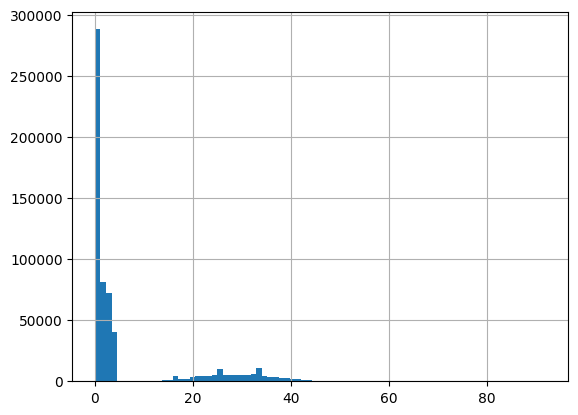

In [21]:
wic_ages.hist(bins=81)

<AxesSubplot: >

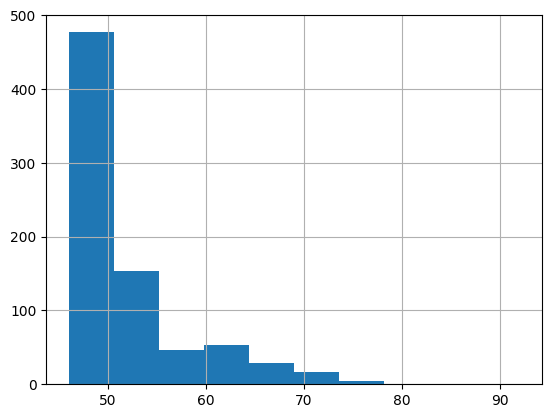

In [22]:
wic_ages.loc[wic_ages>45].hist()

In [23]:
wic_ages.loc[wic_ages>50].value_counts()

51.0    44
53.0    36
52.0    31
54.0    22
55.0    20
62.0    16
56.0    14
58.0    13
61.0    12
60.0    11
67.0    10
57.0    10
59.0     9
64.0     8
65.0     7
69.0     7
63.0     6
68.0     6
66.0     6
73.0     5
78.0     2
70.0     2
71.0     2
77.0     1
72.0     1
75.0     1
79.0     1
87.0     1
92.0     1
76.0     1
Name: age, dtype: int64

(0.0, 18.0)

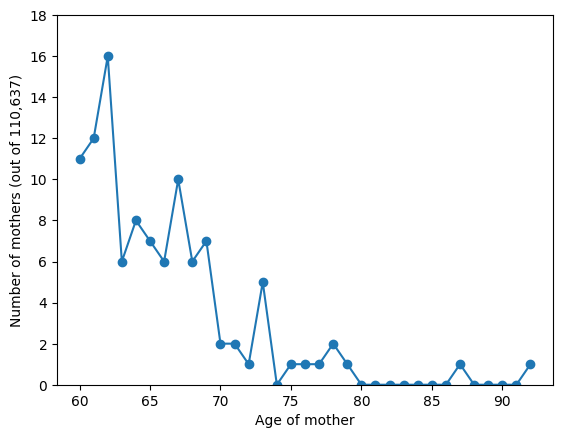

In [44]:
total_num_mothers = len(wic_ages.loc[wic_ages>=5])
older_mothers = wic_ages.loc[wic_ages>=60].value_counts().sort_index()
age_counts = pd.DataFrame(index=range(60,93)).join(older_mothers).fillna(0).squeeze()
plt.plot(age_counts.index, age_counts, marker='o')
plt.xlabel("Age of mother")
plt.ylabel(f"Number of mothers (out of {total_num_mothers:,})")
plt.ylim(0,18)

(0.0, 350.0)

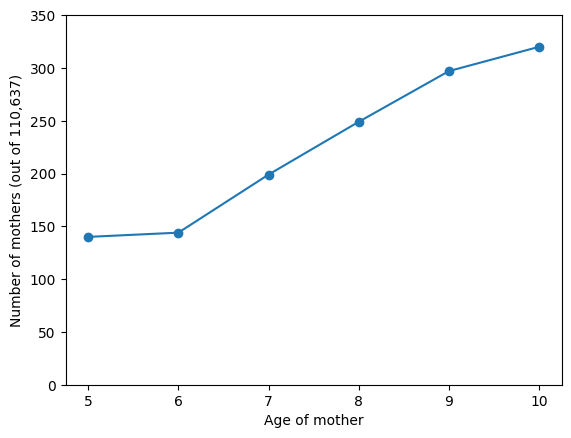

In [25]:
young_mothers = wic_ages.loc[(wic_ages>4) & (wic_ages<=10)].value_counts().sort_index()
plt.plot(young_mothers.index, young_mothers, marker='o')
plt.xlabel("Age of mother")
plt.ylabel(f"Number of mothers (out of {total_num_mothers:,})")
plt.ylim(0,350)

# See how big the 2020 and 2030 censuses are

About 2.5M people in 2020 and 2.4M people in 2030

In [26]:
df_census.census_year.value_counts()

2020    2498237
2030    2445048
Name: census_year, dtype: int64

# See how long some noise functions take on census data

## Copy census data once and add noise in place on copy

In [27]:
%%time
df_census_noisy = df_census.copy()

CPU times: user 251 ms, sys: 221 ms, total: 471 ms
Wall time: 469 ms


In [28]:
rng = np.random.default_rng(1010192929283838474)
rng

Generator(PCG64) at 0x7F38C5580E40

In [29]:
# See if DOB is a string so that month/day swapping will work - yes, it is
type(df_census.loc[0,'date_of_birth'])

str

## First test a few functions with 1% error rate

In [30]:
%%time
noisify.apply_noise_function_to_column( # Replace random 1% with random fake name
        df_census_noisy, 'first_name', 0.01, rng,
        corruption.random_choice, (fake_names.fake_first_names('title'),), inplace=True)

CPU times: user 75.2 ms, sys: 3.94 ms, total: 79.1 ms
Wall time: 77.9 ms


In [31]:
%%time
noisify.apply_noise_function_to_column(
        df_census_noisy, 'date_of_birth', 0.01, rng,
        corruption.swap_month_day, share_random_state=False, inplace=True)

CPU times: user 168 ms, sys: 15.8 ms, total: 184 ms
Wall time: 183 ms


In [32]:
%%time
noisify.apply_noise_function_to_column(
        df_census_noisy, 'first_name', 0.01, rng,
        corruption.phonetic_corrupt, (1/6,), vectorized=False, inplace=True)

CPU times: user 1.67 s, sys: 75.3 ms, total: 1.75 s
Wall time: 1.64 s


## Now try same functions with 10% error rate

In [33]:
%%time
noisify.apply_noise_function_to_column( # Replace random 10% with random fake name
        df_census_noisy, 'first_name', 0.1, rng,
        corruption.random_choice, (fake_names.fake_first_names('title'),), inplace=True)

CPU times: user 199 ms, sys: 11.7 ms, total: 211 ms
Wall time: 209 ms


In [34]:
%%time
noisify.apply_noise_function_to_column(
        df_census_noisy, 'date_of_birth', 0.1, rng,
        corruption.swap_month_day, share_random_state=False, inplace=True)

CPU times: user 1.28 s, sys: 60 ms, total: 1.34 s
Wall time: 1.34 s


In [35]:
%%time
noisify.apply_noise_function_to_column(
        df_census_noisy, 'first_name', 0.1, rng,
        corruption.phonetic_corrupt, (1/6,), vectorized=False, inplace=True)

CPU times: user 14.9 s, sys: 377 ms, total: 15.2 s
Wall time: 14.9 s


## Estimate time per noise function on 1% of full census data

The above functions take between ~0.1s and ~2s on 1% of data.

That scales to between ~13s and 270s = 4.5min **per noise function per column** for the full census. That seems like too long, unless we can parallelize it...

In [36]:
np.array([0.1, 2]) * (2*330e6) / len(df_census)

array([ 13.35144545, 267.02890891])

In [37]:
270/60

4.5